Random Forest - 均方误差（MSE）：1.3210627817308082e-05
Random Forest - R²：-10.075331012748103


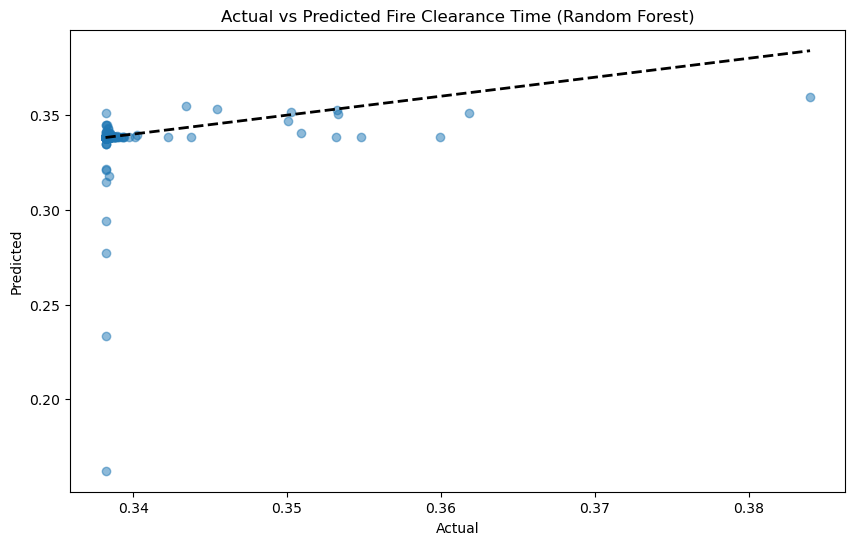

Gradient Boosting - 均方误差（MSE）：2.6827016136454656e-05
Gradient Boosting - R²：-21.49083752146108


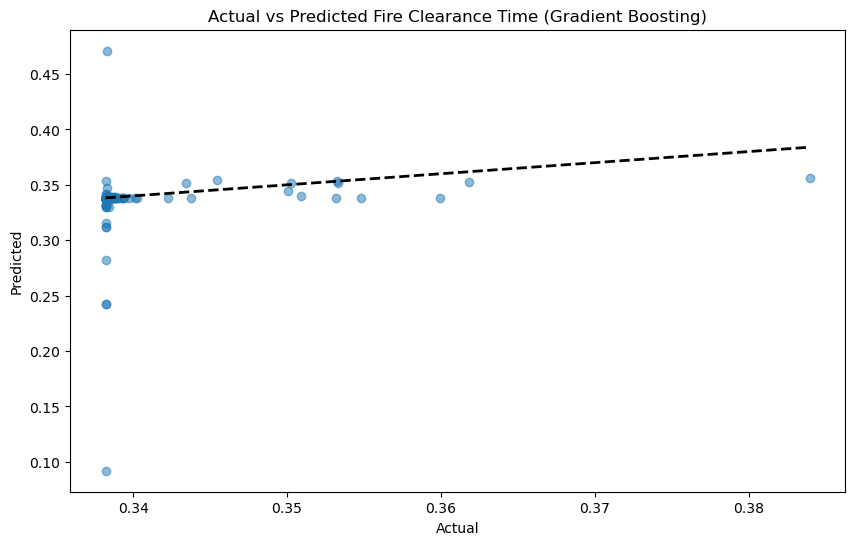

Support Vector Regressor - 均方误差（MSE）：0.005582544270886
Support Vector Regressor - R²：-4679.2110049892935


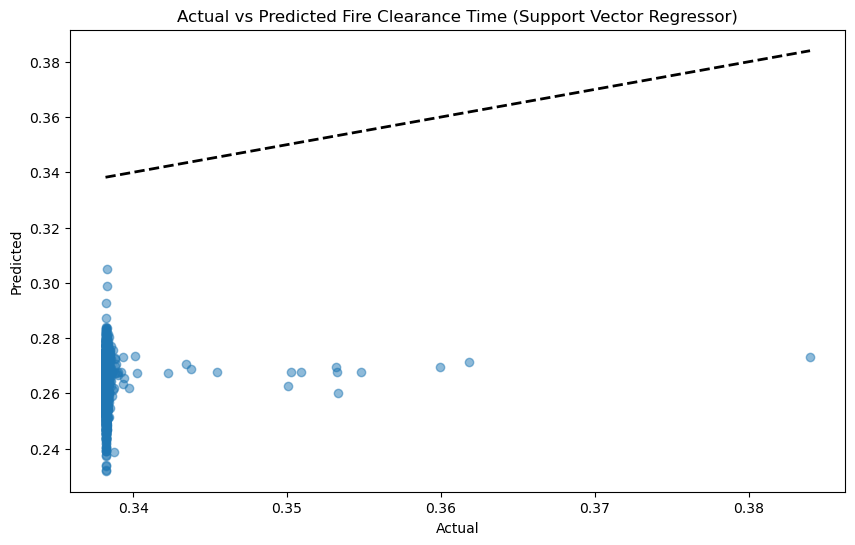

/opt/conda/lib/python3.11/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


XGBoost - 均方误差（MSE）：7.444923451438779e-07
XGBoost - R²：0.37584350471802686


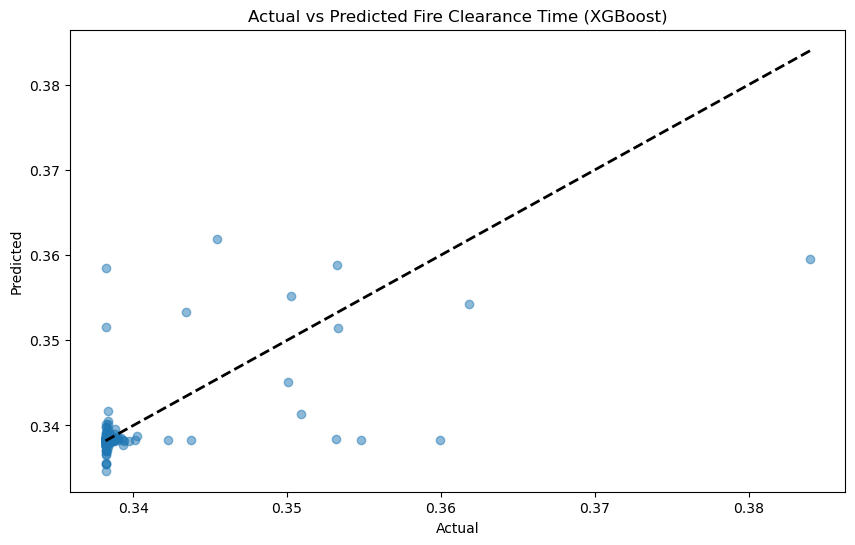

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003982 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1366
[LightGBM] [Info] Number of data points in the train set: 15621, number of used features: 81
[LightGBM] [Info] Start training from score 0.338179
LightGBM - 均方误差（MSE）：2.2762269195507817e-06
LightGBM - R²：-0.9083095022269632


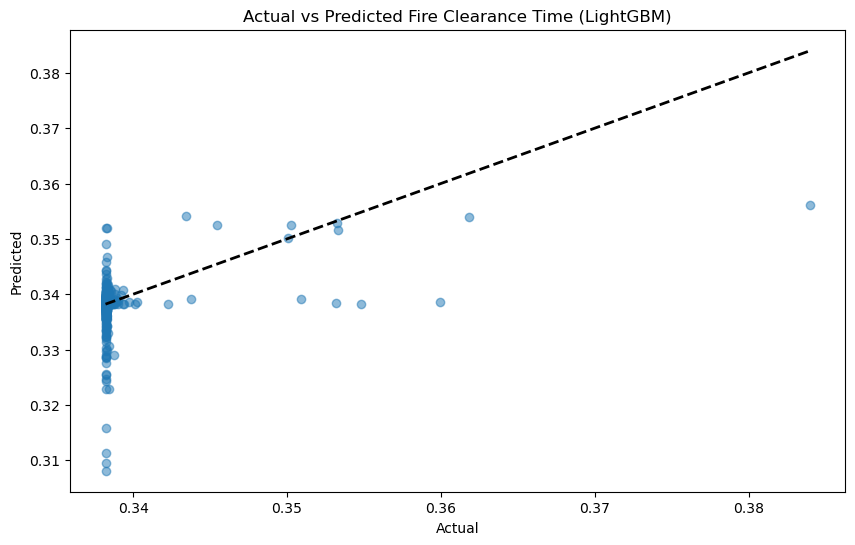

                                   MSE           R²
Random Forest             1.321063e-05   -10.075331
Gradient Boosting         2.682702e-05   -21.490838
Support Vector Regressor  5.582544e-03 -4679.211005
XGBoost                   7.444923e-07     0.375844
LightGBM                  2.276227e-06    -0.908310


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

# 读取数据并指定可能有混合类型的列类型为字符串
data_file = 'morans_data/2021/processed_2021_onehot_normalized.csv'
dtype_spec = {
    'ACT_TAK2': str,
    'DET_ALERT': str,
    'INC_CATEGORY': str,
    'PROP_CATEGORY': str
}
data = pd.read_csv(data_file, dtype=dtype_spec, low_memory=False)

# 删除不需要的列
columns_to_drop = ['INCIDENT_KEY', 'STATE', 'INC_DATE', 'INC_NO', 'EXP_NO', 'VERSION', 'DEPT_STA', 
                   'ADD_WILD', 'AID', 'ALARM', 'ARRIVAL', 'LU_CLEAR', 'SHIFT', 'ALARMS', 
                   'DISTRICT', 'APP_MOD', 'EMS_APP', 'OTH_APP', 'EMS_PER', 'OTH_PER', 
                   'RESOU_AID', 'HAZ_REL', 'MIXED_USE', 'PROP_USE', 'CENSUS']
data = data.drop(columns=columns_to_drop, errors='ignore')

# 确认数值列和类别列
numeric_columns = data.select_dtypes(include=[np.number]).columns
categorical_columns = data.select_dtypes(include=['object']).columns

# 对非数值数据进行 One-Hot 编码
data_encoded = pd.get_dummies(data, columns=categorical_columns)

# 填充 NaN 值为均值
imputer = SimpleImputer(strategy='mean')
X = pd.DataFrame(imputer.fit_transform(data_encoded.drop(columns=['FIRE_CLEARANCE_TIME'])), columns=data_encoded.drop(columns=['FIRE_CLEARANCE_TIME']).columns)
y = data_encoded['FIRE_CLEARANCE_TIME']

# 随机抽取部分数据进行建模 (抽取10%的数据)
X_sampled, _, y_sampled, _ = train_test_split(X, y, train_size=0.1, random_state=42)

# 拆分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X_sampled, y_sampled, test_size=0.2, random_state=42)

# 标准化数值型特征
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 定义模型
models = {
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'Support Vector Regressor': SVR(),
    'XGBoost': XGBRegressor(random_state=42),
    'LightGBM': LGBMRegressor(random_state=42)
}

# 评估所有模型
results = {}
for model_name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results[model_name] = (mse, r2)
    
    print(f"{model_name} - 均方误差（MSE）：{mse}")
    print(f"{model_name} - R²：{r2}")

    # 可视化
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'Actual vs Predicted Fire Clearance Time ({model_name})')
    plt.show()

# 输出结果表
results_df = pd.DataFrame(results, index=['MSE', 'R²']).T
print(results_df)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     39056

    accuracy                           1.00     39056
   macro avg       1.00      1.00      1.00     39056
weighted avg       1.00      1.00      1.00     39056



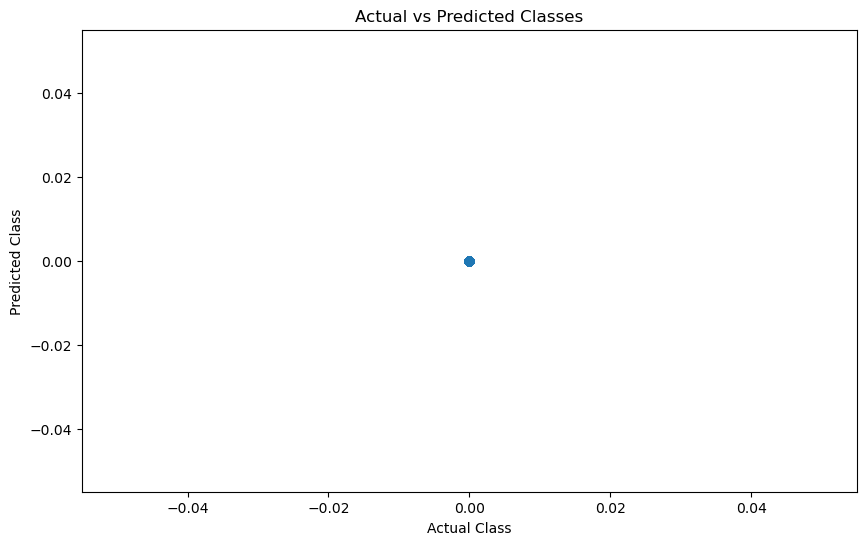

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer

# 读取数据并指定可能有混合类型的列类型为字符串
data_file = 'morans_data/2021/processed_2021_onehot_normalized.csv'
dtype_spec = {
    'ACT_TAK2': str,
    'DET_ALERT': str,
    'INC_CATEGORY': str,
    'PROP_CATEGORY': str
}
data = pd.read_csv(data_file, dtype=dtype_spec, low_memory=False)

# 删除不需要的列
columns_to_drop = ['INCIDENT_KEY', 'STATE', 'INC_DATE', 'INC_NO', 'EXP_NO', 'VERSION', 'DEPT_STA', 
                   'ADD_WILD', 'AID', 'ALARM', 'ARRIVAL', 'LU_CLEAR', 'SHIFT', 'ALARMS', 
                   'DISTRICT', 'APP_MOD', 'EMS_APP', 'OTH_APP', 'EMS_PER', 'OTH_PER', 
                   'RESOU_AID', 'HAZ_REL', 'MIXED_USE', 'PROP_USE', 'CENSUS']
data = data.drop(columns=columns_to_drop, errors='ignore')

# 确认数值列和类别列
numeric_columns = data.select_dtypes(include=[np.number]).columns
categorical_columns = data.select_dtypes(include=['object']).columns

# 对非数值数据进行 One-Hot 编码
data_encoded = pd.get_dummies(data, columns=categorical_columns)

# 填充 NaN 值为均值
imputer = SimpleImputer(strategy='mean')
X = pd.DataFrame(imputer.fit_transform(data_encoded.drop(columns=['FIRE_CLEARANCE_TIME'])), columns=data_encoded.drop(columns=['FIRE_CLEARANCE_TIME']).columns)
y = data_encoded['FIRE_CLEARANCE_TIME']

# 将连续的目标变量分为多个区间
bins = [0, 10, 20, 30, 60, 120, np.inf]
labels = ['Very Short', 'Short', 'Medium', 'Long', 'Very Long', 'Extremely Long']
y_binned = pd.cut(y, bins=bins, labels=labels)

# 将分类任务转化为数值编码
le = LabelEncoder()
y_class = le.fit_transform(y_binned)

# 拆分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y_class, test_size=0.2, random_state=42)

# 标准化数值型特征
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 定义和训练分类模型
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_scaled, y_train)

# 预测和评估
y_pred = clf.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

# 可视化实际类别和预测类别的对比（需要适当修改以适应实际类别标签）
# 注意：在实际使用中需要根据分类报告的结果调整标签和图示
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual Class')
plt.ylabel('Predicted Class')
plt.title('Actual vs Predicted Classes')
plt.show()


/tmp/ipykernel_88767/3827381837.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sampled_chunk = chunk_filtered.groupby(pd.cut(chunk_filtered['FIRE_CLEARANCE_TIME'], bins=[0,10,15,20,30,40, 50]), group_keys=False).apply(lambda x: x.sample(frac=0.1))
/tmp/ipykernel_88767/3827381837.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sampled_chunk = chunk_filtered.groupby(pd.cut(chunk_filtered['FIRE_CLEARANCE_TIME'], bins=[0,10,15,20,30,40, 50]), group_keys=False).apply(lambda x: x.sample(frac=0.1))
/tmp/ipykernel_88767/3827381837.py:32: FutureWarning: The default of observed=False is deprecated and will b

抽样后的数据量: 4022 条记录
Training Random Forest...
Random Forest - classification report:
                precision    recall  f1-score   support

Extremely Long       0.11      0.04      0.06        67
          Long       0.22      0.15      0.18       132
        Medium       0.17      0.04      0.07        93
         Short       0.23      0.05      0.08       120
     Very Long       0.33      0.17      0.23        92
    Very Short       0.44      0.86      0.58       301

      accuracy                           0.38       805
     macro avg       0.25      0.22      0.20       805
  weighted avg       0.30      0.38      0.30       805



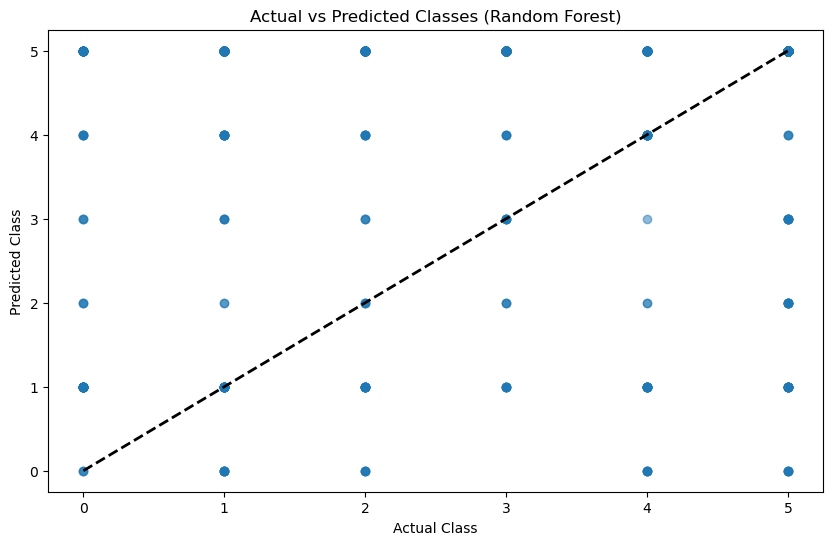

Training Gradient Boosting...
Gradient Boosting - classification report:
                precision    recall  f1-score   support

Extremely Long       0.33      0.12      0.18        67
          Long       0.27      0.14      0.19       132
        Medium       0.00      0.00      0.00        93
         Short       0.23      0.06      0.09       120
     Very Long       0.31      0.13      0.18        92
    Very Short       0.44      0.92      0.60       301

      accuracy                           0.40       805
     macro avg       0.26      0.23      0.21       805
  weighted avg       0.31      0.40      0.30       805



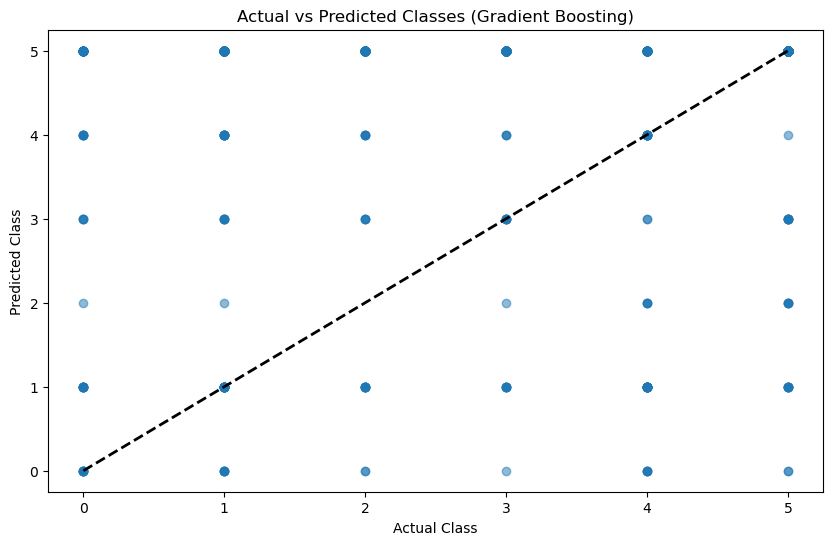

Training Support Vector Classifier...
Support Vector Classifier - classification report:
                precision    recall  f1-score   support

Extremely Long       0.17      0.01      0.03        67
          Long       0.24      0.12      0.16       132
        Medium       0.00      0.00      0.00        93
         Short       0.20      0.03      0.06       120
     Very Long       0.18      0.02      0.04        92
    Very Short       0.40      0.92      0.56       301

      accuracy                           0.37       805
     macro avg       0.20      0.19      0.14       805
  weighted avg       0.25      0.37      0.25       805



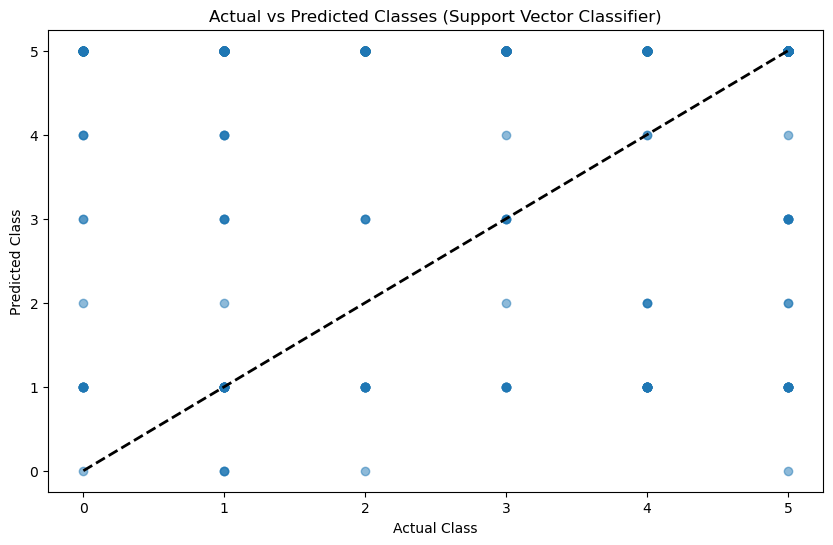

Training XGBoost...
XGBoost - classification report:
                precision    recall  f1-score   support

Extremely Long       0.24      0.12      0.16        67
          Long       0.22      0.17      0.19       132
        Medium       0.07      0.02      0.03        93
         Short       0.12      0.07      0.09       120
     Very Long       0.24      0.13      0.17        92
    Very Short       0.48      0.83      0.61       301

      accuracy                           0.38       805
     macro avg       0.23      0.22      0.21       805
  weighted avg       0.29      0.38      0.31       805



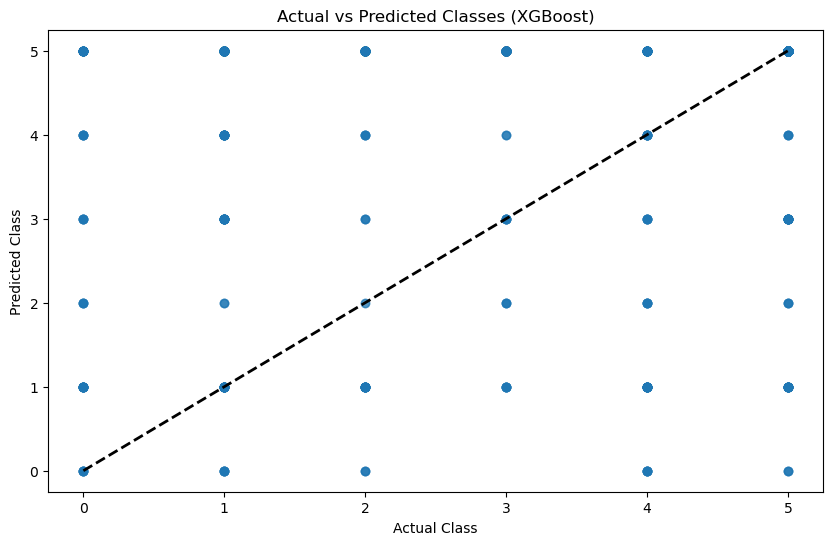

Training LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003170 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 3217, number of used features: 748
[LightGBM] [Info] Start training from score -2.481493
[LightGBM] [Info] Start training from score -1.810903
[LightGBM] [Info] Start training from score -2.157311
[LightGBM] [Info] Start training from score -1.906594
[LightGBM] [Info] Start training from score -2.165408
[LightGBM] [Info] Start training from score -0.983631
LightGBM - classification report:
                precision    recall  f1-score   support

Extremely Long       0.23      0.12      0.16        67
          Long       0.23      0.18      0.20       132
        Medium       0.10      0.05      0.07        93
         Short       0.14      0.07      0.

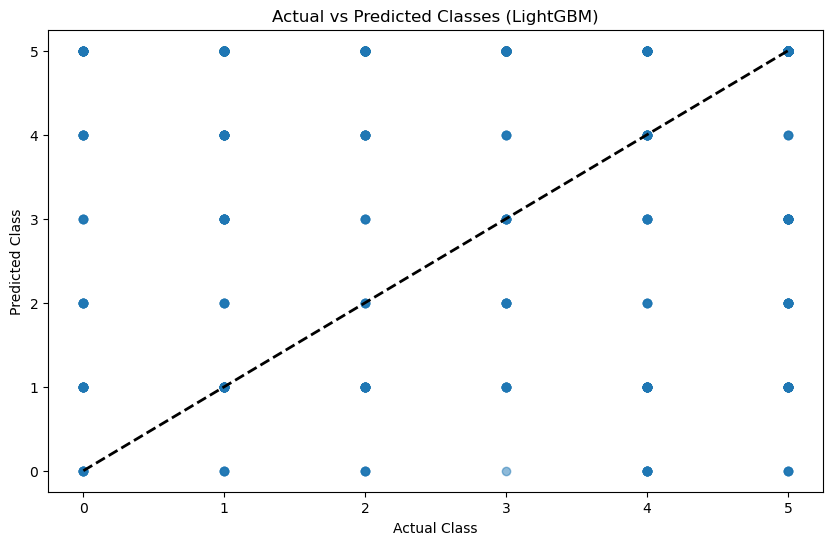


Random Forest - F1 Scores by Class:
Extremely Long: 0.063
Long: 0.179
Medium: 0.069
Short: 0.082
Very Long: 0.229
Very Short: 0.584
macro avg: 0.201
weighted avg: 0.299

Gradient Boosting - F1 Scores by Class:
Extremely Long: 0.176
Long: 0.187
Medium: 0.000
Short: 0.093
Very Long: 0.183
Very Short: 0.596
macro avg: 0.206
weighted avg: 0.303

Support Vector Classifier - F1 Scores by Class:
Extremely Long: 0.027
Long: 0.161
Medium: 0.000
Short: 0.057
Very Long: 0.039
Very Short: 0.559
macro avg: 0.141
weighted avg: 0.251

XGBoost - F1 Scores by Class:
Extremely Long: 0.160
Long: 0.193
Medium: 0.033
Short: 0.087
Very Long: 0.168
Very Short: 0.605
macro avg: 0.208
weighted avg: 0.307

LightGBM - F1 Scores by Class:
Extremely Long: 0.157
Long: 0.202
Medium: 0.071
Short: 0.098
Very Long: 0.181
Very Short: 0.597
macro avg: 0.218
weighted avg: 0.313


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

# 使用更小的chunksize逐步读取数据
dtype_spec = {
    'FDID': 'float32',
    'PROP_LOSS': 'float32',
    'CONT_LOSS': 'float32',
    'PROP_VAL': 'float32',
    'CONT_VAL': 'float32',
    'RESPONSE_TIME': 'float32',
    'FIRE_CLEARANCE_TIME': 'float32',
    **{col: 'float32' for col in pd.read_csv('morans_data/2021/basicincident_processed_final_2021.csv', nrows=1).columns if col.startswith(('INC_TYPE_', 'DISTRICT_', 'PROP_USE_'))}
}

# 分块读取数据并进行分层抽样
chunks = []
for chunk in pd.read_csv('morans_data/2021/basicincident_processed_final_2021.csv', dtype=dtype_spec, chunksize=1000):
    # 筛选数据
    chunk_filtered = chunk[(chunk['FIRE_CLEARANCE_TIME'] >= 0) & (chunk['FIRE_CLEARANCE_TIME'] <= 50) &
                           (chunk['RESPONSE_TIME'] >= 0) & (chunk['RESPONSE_TIME'] <= 34)]
    # 分层抽样
    sampled_chunk = chunk_filtered.groupby(pd.cut(chunk_filtered['FIRE_CLEARANCE_TIME'], bins=[0,10,15,20,30,40, 50]), group_keys=False).apply(lambda x: x.sample(frac=0.1))
    chunks.append(sampled_chunk)

# 将所有块组合成一个 DataFrame
filtered_data = pd.concat(chunks, ignore_index=True)

# 显示抽样后的数据量
print(f"抽样后的数据量: {filtered_data.shape[0]} 条记录")

# 分离特征和目标变量
X = filtered_data.drop(columns=['FIRE_CLEARANCE_TIME'])
y = filtered_data['FIRE_CLEARANCE_TIME']

# 使用SimpleImputer填补缺失值
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# 分箱策略
bins = [0,10,15,20,30,40, 50]
labels = ['Very Short', 'Short', 'Medium', 'Long', 'Very Long', 'Extremely Long']
y_binned = pd.cut(y, bins=bins, labels=labels)

# 将分类任务转化为数值编码
le = LabelEncoder()
y_class = le.fit_transform(y_binned)

# 拆分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y_class, test_size=0.2, random_state=42, stratify=y_class)

# 标准化数值型特征
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 定义模型字典
models = {
    'Random Forest': RandomForestClassifier(random_state=42, class_weight='balanced'),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Support Vector Classifier': SVC(probability=True, random_state=42),
    'XGBoost': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss'),
    'LightGBM': LGBMClassifier(random_state=42)
}

# 评估所有模型
results = {}
for model_name, model in models.items():
    print(f"Training {model_name}...")
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    report = classification_report(y_test, y_pred, target_names=le.classes_, output_dict=True)
    results[model_name] = report
    
    print(f"{model_name} - classification report:")
    print(classification_report(y_test, y_pred, target_names=le.classes_))
    
    # 可视化
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([0, len(le.classes_)-1], [0, len(le.classes_)-1], 'k--', lw=2)
    plt.xlabel('Actual Class')
    plt.ylabel('Predicted Class')
    plt.title(f'Actual vs Predicted Classes ({model_name})')
    plt.show()

# 比较结果表
for model_name, report in results.items():
    print(f"\n{model_name} - F1 Scores by Class:")
    for label, metrics in report.items():
        if isinstance(metrics, dict):
            print(f"{label}: {metrics['f1-score']:.3f}")


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold

# 使用更小的chunksize逐步读取数据
dtype_spec = {
    'FDID': 'float32',
    'PROP_LOSS': 'float32',
    'CONT_LOSS': 'float32',
    'PROP_VAL': 'float32',
    'CONT_VAL': 'float32',
    'RESPONSE_TIME': 'float32',
    'FIRE_CLEARANCE_TIME': 'float32',
    **{col: 'float32' for col in pd.read_csv('morans_data/2021/basicincident_processed_final_2021.csv', nrows=1).columns if col.startswith(('INC_TYPE_', 'DISTRICT_', 'PROP_USE_'))}
}

# 分块读取数据并进行分层抽样
chunks = []
for chunk in pd.read_csv('morans_data/2021/basicincident_processed_final_2021.csv', dtype=dtype_spec, chunksize=1000):
    # 筛选数据
    chunk_filtered = chunk[(chunk['FIRE_CLEARANCE_TIME'] >= 0) & (chunk['FIRE_CLEARANCE_TIME'] <= 600) &
                           (chunk['RESPONSE_TIME'] >= 0) & (chunk['RESPONSE_TIME'] <= 34)]
    # 分层抽样
    sampled_chunk = chunk_filtered.groupby(pd.cut(chunk_filtered['FIRE_CLEARANCE_TIME'], bins=[0, 50, 100, 200, 300, 400, 600]), group_keys=False).apply(lambda x: x.sample(frac=0.1))
    chunks.append(sampled_chunk)

# 将所有块组合成一个 DataFrame
filtered_data = pd.concat(chunks, ignore_index=True)

# 显示抽样后的数据量
print(f"抽样后的数据量: {filtered_data.shape[0]} 条记录")

# 特征工程：创建新的交互特征
filtered_data['PROP_LOSS_RESPONSE_TIME'] = filtered_data['PROP_LOSS'] * filtered_data['RESPONSE_TIME']
filtered_data['CONT_LOSS_RESPONSE_TIME'] = filtered_data['CONT_LOSS'] * filtered_data['RESPONSE_TIME']

# 分离特征和目标变量
X = filtered_data.drop(columns=['FIRE_CLEARANCE_TIME'])
y = filtered_data['FIRE_CLEARANCE_TIME']

# 使用SimpleImputer填补缺失值
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# 分箱策略
bins = [0, 50, 100, 200, 300, 400, 600]
labels = ['Very Short', 'Short', 'Medium', 'Long', 'Very Long', 'Extremely Long']
y_binned = pd.cut(y, bins=bins, labels=labels)

# 将分类任务转化为数值编码
le = LabelEncoder()
y_class = le.fit_transform(y_binned)

# 拆分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y_class, test_size=0.2, random_state=42, stratify=y_class)

# 处理数据不平衡问题：使用SMOTE进行过采样
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# 定义模型和参数网格进行优化
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'colsample_bytree': [0.3, 0.7, 1.0]
}

# 使用随机搜索进行超参数优化
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
random_search = RandomizedSearchCV(estimator=xgb, param_distributions=param_grid, n_iter=10, scoring='f1_macro', cv=cv, random_state=42, n_jobs=-1)
random_search.fit(X_train_resampled, y_train_resampled)

# 最优模型评估
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

# 输出分类报告
print("最佳模型的分类报告：")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# 可视化实际类别与预测类别
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([0, len(le.classes_)-1], [0, len(le.classes_)-1], 'k--', lw=2)
plt.xlabel('Actual Class')
plt.ylabel('Predicted Class')
plt.title(f'Actual vs Predicted Classes (XGBoost with SMOTE and Hyperparameter Tuning)')
plt.show()


/tmp/ipykernel_88767/3054034727.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sampled_chunk = chunk_filtered.groupby(pd.cut(chunk_filtered['FIRE_CLEARANCE_TIME'], bins=[0, 50, 100, 200, 300, 400, 600]), group_keys=False).apply(lambda x: x.sample(frac=0.1))
/tmp/ipykernel_88767/3054034727.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sampled_chunk = chunk_filtered.groupby(pd.cut(chunk_filtered['FIRE_CLEARANCE_TIME'], bins=[0, 50, 100, 200, 300, 400, 600]), group_keys=False).apply(lambda x: x.sample(frac=0.1))
/tmp/ipykernel_88767/3054034727.py:32: FutureWarning: The default of observed=False is d

抽样后的数据量: 4973 条记录


TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.

The exit codes of the workers are {SIGKILL(-9)}

/tmp/ipykernel_87200/1545741597.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sampled_chunk = chunk_filtered.groupby(pd.cut(chunk_filtered['FIRE_CLEARANCE_TIME'], bins=[0, 50, 100, 200, 300, 400, 600]), group_keys=False).apply(lambda x: x.sample(frac=0.1))
/tmp/ipykernel_87200/1545741597.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sampled_chunk = chunk_filtered.groupby(pd.cut(chunk_filtered['FIRE_CLEARANCE_TIME'], bins=[0, 50, 100, 200, 300, 400, 600]), group_keys=False).apply(lambda x: x.sample(frac=0.1))
/tmp/ipykernel_87200/1545741597.py:29: FutureWarning: The default of observed=False is d

抽样后的数据量: 4973 条记录
              precision    recall  f1-score   support

      Medium       0.75      0.10      0.18        29
       Short       0.48      0.09      0.15       163
  Very Short       0.82      0.99      0.90       803

    accuracy                           0.81       995
   macro avg       0.69      0.39      0.41       995
weighted avg       0.77      0.81      0.75       995



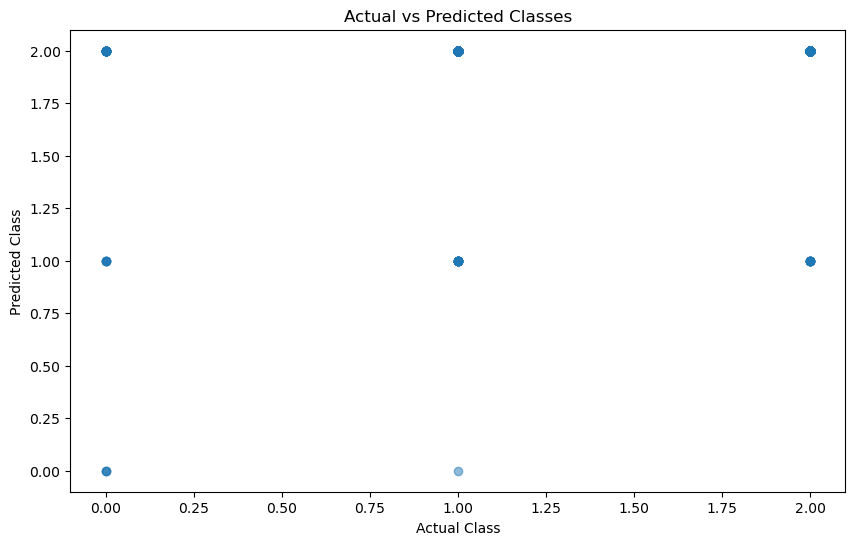

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

# 使用更小的chunksize逐步读取数据
dtype_spec = {
    'FDID': 'float32',
    'PROP_LOSS': 'float32',
    'CONT_LOSS': 'float32',
    'PROP_VAL': 'float32',
    'CONT_VAL': 'float32',
    'RESPONSE_TIME': 'float32',
    'FIRE_CLEARANCE_TIME': 'float32',
    **{col: 'float32' for col in pd.read_csv('morans_data/2021/basicincident_processed_final_2021.csv', nrows=1).columns if col.startswith(('INC_TYPE_', 'DISTRICT_', 'PROP_USE_'))}
}

# 分块读取数据并进行分层抽样
chunks = []
for chunk in pd.read_csv('morans_data/2021/basicincident_processed_final_2021.csv', dtype=dtype_spec, chunksize=1000):
    # 筛选数据
    chunk_filtered = chunk[(chunk['FIRE_CLEARANCE_TIME'] >= 0) & (chunk['FIRE_CLEARANCE_TIME'] <= 600) &
                           (chunk['RESPONSE_TIME'] >= 0) & (chunk['RESPONSE_TIME'] <= 34)]
    # 分层抽样
    sampled_chunk = chunk_filtered.groupby(pd.cut(chunk_filtered['FIRE_CLEARANCE_TIME'], bins=[0, 50, 100, 200, 300, 400, 600]), group_keys=False).apply(lambda x: x.sample(frac=0.1))
    chunks.append(sampled_chunk)

# 将所有块组合成一个 DataFrame
filtered_data = pd.concat(chunks, ignore_index=True)

# 显示抽样后的数据量
print(f"抽样后的数据量: {filtered_data.shape[0]} 条记录")

# 分离特征和目标变量
X = filtered_data.drop(columns=['FIRE_CLEARANCE_TIME'])
y = filtered_data['FIRE_CLEARANCE_TIME']

# 使用SimpleImputer填补缺失值
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# 继续进行数据处理和模型训练
bins = [0, 50, 100, 200, 300, 400, 600]
labels = ['Very Short', 'Short', 'Medium', 'Long', 'Very Long', 'Extremely Long']
y_binned = pd.cut(y, bins=bins, labels=labels)

# 将分类任务转化为数值编码
le = LabelEncoder()
y_class = le.fit_transform(y_binned)

# 拆分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y_class, test_size=0.2, random_state=42, stratify=y_class)

# 标准化数值型特征
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 定义和训练分类模型
clf = RandomForestClassifier(random_state=42, class_weight='balanced')
clf.fit(X_train_scaled, y_train)

# 预测和评估
y_pred = clf.predict(X_test_scaled)
print(classification_report(y_test, y_pred, target_names=le.classes_))

# 可视化实际类别和预测类别的对比
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual Class')
plt.ylabel('Predicted Class')
plt.title('Actual vs Predicted Classes')
plt.show()


In [ ]:
# 对非数值数据进行 One-Hot 编码
data_encoded = pd.get_dummies(data, columns=categorical_columns)

# 分离特征与目标变量
X = data_encoded.drop(columns=['FIRE_CLEARANCE_TIME'])
y = data_encoded['FIRE_CLEARANCE_TIME']

# 填充 NaN 值
imputer = SimpleImputer(strategy='median')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# 拆分数据集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 标准化数值型特征
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 定义模型
models = {
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'Support Vector Regressor': SVR(),
    'XGBoost': XGBRegressor(random_state=42),
    'LightGBM': LGBMRegressor(random_state=42)
}

# 评估所有模型
results = {}
for model_name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results[model_name] = (mse, r2)
    
    print(f"{model_name} - 均方误差（MSE）：{mse}")
    print(f"{model_name} - R²：{r2}")

    # 可视化
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'Actual vs Predicted Fire Clearance Time ({model_name})')
    plt.show()

# 输出结果表
results_df = pd.DataFrame(results, index=['MSE', 'R²']).T
print(results_df)

    

In [13]:
# 检查数据中的非数值条目
non_numeric_columns = []

for col in X.columns:
    # 检查每一列是否能够转换为数值类型
    if X[col].dtype == 'object':
        try:
            X[col].astype(float)
        except ValueError:
            non_numeric_columns.append(col)

print(f"这些列包含非数值数据: {non_numeric_columns}")


这些列包含非数值数据: ['ACT_TAK2', 'DET_ALERT', 'INC_CATEGORY', 'PROP_CATEGORY']


In [19]:
import numpy as np
import pandas as pd

# 计算残差
residuals = np.abs(y_test - y_pred)

# 设置残差的阈值，手动调整阈值大小来识别异常值
threshold = 0.1  # 你可以根据实际情况调整这个值
outliers = residuals > threshold

# 保持索引对齐
X_test_filtered = X_test[~outliers]
y_test_filtered = y_test[~outliers]

# 重新训练模型
pipeline.fit(X_train, y_train)  # 使用完整训练数据进行训练
y_pred_filtered = pipeline.predict(X_test_filtered)

# 评估模型性能
mse_filtered = mean_squared_error(y_test_filtered, y_pred_filtered)
r2_filtered = r2_score(y_test_filtered, y_pred_filtered)

print(f"去除异常值后的线性回归 - 均方误差（MSE）：{mse_filtered}")
print(f"去除异常值后的线性回归 - R²：{r2_filtered}")

# 进行可视化
plt.figure(figsize=(10, 6))
plt.scatter(y_test_filtered, y_pred_filtered, alpha=0.5)
plt.plot([y_test_filtered.min(), y_test_filtered.max()], [y_test_filtered.min(), y_test_filtered.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Fire Clearance Time (Linear Regression)')
plt.show()


NameError: name 'y_pred' is not defined

In [16]:
# 假设选择了 One-Hot Encoding 方法处理非数值列
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# 标准化数值型特征
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 定义模型
models = {
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'Support Vector Regressor': SVR(),
    'XGBoost': XGBRegressor(random_state=42),
    'LightGBM': LGBMRegressor(random_state=42)
}

# 评估所有模型
results = {}
for model_name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results[model_name] = (mse, r2)
    
    print(f"{model_name} - 均方误差（MSE）：{mse}")
    print(f"{model_name} - R²：{r2}")

    # 可视化
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'Actual vs Predicted Fire Clearance Time ({model_name})')
    plt.show()

# 输出结果表
results_df = pd.DataFrame(results, index=['MSE', 'R²']).T
print(results_df)


NameError: name 'X_encoded' is not defined

In [15]:
import pandas as pd
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# 读取数据
data_file = 'morans_data/2021/processed_2021_onehot_normalized.csv'
data = pd.read_csv(data_file)

# 计算每列缺失值的数量和比例
missing_values = data.isnull().sum()
missing_percentage = (missing_values / len(data)) * 100

# 将缺失值数量和比例合并到一个数据框中
missing_data = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage})

# 按缺失值比例从高到低排序
missing_data_sorted = missing_data.sort_values(by='Percentage', ascending=False)

# 根据50%的阈值删除缺失值过多的列
threshold = 50.0
columns_to_keep = missing_data_sorted[missing_data_sorted['Percentage'] <= threshold].index

# 只保留缺失值比例在50%以下的列
filtered_data = data[columns_to_keep]

# 查看处理后的数据框架信息
print(f"处理后的数据集形状 (行数, 列数): {filtered_data.shape}")
print("\n保留的参数（列名）：")
print(filtered_data.columns)

# 显示处理后的数据前几行
print("\n处理后的数据前几行：")
print(filtered_data)


/tmp/ipykernel_67334/1148294555.py:15: DtypeWarning: Columns (7,16,17,19,41) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(data_file)


处理后的数据集形状 (行数, 列数): (195277, 54)

保留的参数（列名）：
Index(['DISTRICT', 'SHIFT', 'CONT_VAL', 'PROP_VAL', 'INC_CATEGORY',
       'CONT_LOSS', 'PROP_LOSS', 'DEPT_STA', 'ADD_WILD', 'APP_MOD',
       'RESOU_AID', 'PROP_USE', 'PROP_CATEGORY', 'FF_DEATH', 'FF_INJ',
       'EMS_APP', 'EMS_PER', 'SUP_PER', 'OTH_APP', 'SUP_APP', 'OTH_PER',
       'ACT_TAK1', 'Mobile property (vehicle) fire', 'Special outside fire',
       'Outside rubbish fire', 'Manufacturing', 'Mercantile', 'Other fires',
       'Natural vegetation fire', 'Storage',
       'Fire in mobile property used as a fixed structure',
       'Cultivated vegetation, crop fire', 'Residential', 'Outside', 'Other',
       'Health Care', 'Industrial', 'INCIDENT_KEY', 'Educational', 'Assembly',
       'FIRE_CLEARANCE_TIME', 'RESPONSE_TIME', 'STATE', 'LU_CLEAR', 'ARRIVAL',
       'ALARM', 'AID', 'INC_TYPE', 'VERSION', 'EXP_NO', 'INC_NO', 'INC_DATE',
       'FDID', 'Structure fire'],
      dtype='object')

处理后的数据前几行：
       DISTRICT SHIFT      CONT_VA

In [2]:
# 检查 'FIRE_CLEARANCE_TIME' 是否在数据集中
if 'FIRE_CLEARANCE_TIME' in filtered_data.columns:
    print("'FIRE_CLEARANCE_TIME' 列存在于数据集中")
else:
    print("'FIRE_CLEARANCE_TIME' 列不存在于数据集中")


'FIRE_CLEARANCE_TIME' 列存在于数据集中


In [3]:
# 打印所有列名，检查是否有拼写错误或多余的空格
print(filtered_data.columns)


Index(['DISTRICT', 'SHIFT', 'CONT_VAL', 'PROP_VAL', 'INC_CATEGORY',
       'CONT_LOSS', 'PROP_LOSS', 'DEPT_STA', 'ADD_WILD', 'APP_MOD',
       'RESOU_AID', 'PROP_USE', 'PROP_CATEGORY', 'FF_DEATH', 'FF_INJ',
       'EMS_APP', 'EMS_PER', 'SUP_PER', 'OTH_APP', 'SUP_APP', 'OTH_PER',
       'ACT_TAK1', 'Mobile property (vehicle) fire', 'Special outside fire',
       'Outside rubbish fire', 'Manufacturing', 'Mercantile', 'Other fires',
       'Natural vegetation fire', 'Storage',
       'Fire in mobile property used as a fixed structure',
       'Cultivated vegetation, crop fire', 'Residential', 'Outside', 'Other',
       'Health Care', 'Industrial', 'INCIDENT_KEY', 'Educational', 'Assembly',
       'FIRE_CLEARANCE_TIME', 'RESPONSE_TIME', 'STATE', 'LU_CLEAR', 'ARRIVAL',
       'ALARM', 'AID', 'INC_TYPE', 'VERSION', 'EXP_NO', 'INC_NO', 'INC_DATE',
       'FDID', 'Structure fire'],
      dtype='object')


In [17]:
# 不去除异常值，直接进行建模
data_file = 'morans_data/2021/processed_2021_onehot_normalized.csv'
data = pd.read_csv(data_file)

# 删除不需要的列
columns_to_drop = ['INCIDENT_KEY', 'STATE', 'INC_DATE', 'INC_NO', 'EXP_NO', 'VERSION', 'DEPT_STA', 
                   'ADD_WILD', 'AID', 'ALARM', 'ARRIVAL', 'LU_CLEAR', 'SHIFT', 'ALARMS', 
                   'DISTRICT', 'APP_MOD', 'EMS_APP', 'OTH_APP', 'EMS_PER', 'OTH_PER', 
                   'RESOU_AID', 'HAZ_REL', 'MIXED_USE', 'PROP_USE', 'CENSUS']
columns_to_drop = [col for col in columns_to_drop if col in data.columns]
data = data.drop(columns=columns_to_drop)

# 分离特征变量和目标变量
X = data.drop(columns=['FIRE_CLEARANCE_TIME'])
y = data['FIRE_CLEARANCE_TIME']

# 检查数值型和类别型特征
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

# 将类别型列转换为字符串类型
X[categorical_cols] = X[categorical_cols].astype(str)

# 创建预处理管道：填补缺失值并标准化和编码
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),  # 用均值填充数值型特征的缺失值
            ('scaler', StandardScaler())]), numerical_cols),  # 确保将数值列传递给Pipeline
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),  # 用最频繁的值填充类别型特征的缺失值
            ('encoder', OneHotEncoder(handle_unknown='ignore'))]), categorical_cols)  # 确保将类别列传递给Pipeline
    ])

# 分割数据集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 逐步调试模型评估
pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', LinearRegression())])

# 训练和评估模型
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"线性回归 - 均方误差（MSE）：{mse}")
print(f"线性回归 - R²：{r2}")

# 进行可视化
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Fire Clearance Time (Linear Regression)')
plt.show()


/tmp/ipykernel_67334/808798259.py:3: DtypeWarning: Columns (7,16,17,19,41) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(data_file)


NameError: name 'LinearRegression' is not defined

In [18]:
import numpy as np
import pandas as pd

# 计算残差
residuals = np.abs(y_test - y_pred)

# 设置残差的阈值，手动调整阈值大小来识别异常值
threshold = 0.1  # 你可以根据实际情况调整这个值
outliers = residuals > threshold

# 保持索引对齐
X_test_filtered = X_test[~outliers]
y_test_filtered = y_test[~outliers]

# 重新训练模型
pipeline.fit(X_train, y_train)  # 使用完整训练数据进行训练
y_pred_filtered = pipeline.predict(X_test_filtered)

# 评估模型性能
mse_filtered = mean_squared_error(y_test_filtered, y_pred_filtered)
r2_filtered = r2_score(y_test_filtered, y_pred_filtered)

print(f"去除异常值后的线性回归 - 均方误差（MSE）：{mse_filtered}")
print(f"去除异常值后的线性回归 - R²：{r2_filtered}")

# 进行可视化
plt.figure(figsize=(10, 6))
plt.scatter(y_test_filtered, y_pred_filtered, alpha=0.5)
plt.plot([y_test_filtered.min(), y_test_filtered.max()], [y_test_filtered.min(), y_test_filtered.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Fire Clearance Time (Linear Regression)')
plt.show()


NameError: name 'y_pred' is not defined

In [ ]:
columns_to_drop = ['INCIDENT_KEY', 'ACT_TAK1', 'ACT_TAK2', 'ACT_TAK3','STATE', 'INC_DATE', 'INC_NO', 'EXP_NO', 'VERSION', 'DEPT_STA', 
                   'ADD_WILD', 'AID', 'ALARM', 'ARRIVAL', 'LU_CLEAR', 'SHIFT', 'ALARMS', 
                   'DISTRICT', 'APP_MOD', 'EMS_APP', 'OTH_APP', 'EMS_PER', 'OTH_PER', 
                   'RESOU_AID', 'HAZ_REL', 'MIXED_USE', 'PROP_USE', 'CENSUS']
